In [1]:
"""
一个回归问题的建模实例
"""

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')

In [4]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


## 数值特征归一化，类别特征做one hot

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # apply的这种写法有点诡异，需要注意
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 用0填充缺失值

In [8]:
all_features[numeric_features][:5]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619


In [9]:
all_features.shape

(2919, 79)

In [10]:
# one hot
all_features = pd.get_dummies(all_features, dummy_na=True) # dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征

In [11]:
all_features.shape

(2919, 331)

In [12]:
all_features[:5]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [13]:
# 把train和test分开，加上label
n_train = train_data.shape[0]
train_features_all = np.array(all_features[:n_train].values,dtype=np.float)
test_features = np.array(all_features[n_train:].values,dtype=np.float)
train_labels_all = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=np.float)

## 划分训练集和验证集

In [14]:
idx_shuffle = [x for x in range(n_train)]
np.random.shuffle(idx_shuffle)
idx_shuffle[:5]

[983, 426, 735, 1174, 952]

In [15]:
train_num = int(np.floor(n_train * 0.8))
train_num

1168

In [16]:
valid_features = train_features_all[train_num:]
valid_labels = train_labels_all[train_num:]
train_features = train_features_all[:train_num]
train_labels = train_labels_all[:train_num]

## 建模

In [17]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)
                                    ]) # 回归问题是这么设置的？

In [18]:
model.compile(loss=tf.keras.losses.mean_squared_logarithmic_error, 
              optimizer=tf.keras.optimizers.Adam(0.2))

In [19]:
history=model.fit(train_features, 
                  train_labels,
                  validation_data=(valid_features, valid_labels), 
                  epochs=200, 
                  batch_size=128,
                  validation_freq=1,
                  verbose=1)


Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 1s 530us/sample - loss: 83.7847 - val_loss: 65.8267
Epoch 2/500
1168/1168 [==============================] - 0s 26us/sample - loss: 62.8248 - val_loss: 59.9730
Epoch 3/500
1168/1168 [==============================] - 0s 24us/sample - loss: 58.5891 - val_loss: 57.2218
Epoch 4/500
1168/1168 [==============================] - 0s 43us/sample - loss: 56.3119 - val_loss: 55.4553
Epoch 5/500
1168/1168 [==============================] - 0s 46us/sample - loss: 54.7394 - val_loss: 54.1060
Epoch 6/500
1168/1168 [==============================] - 0s 38us/sample - loss: 53.4834 - val_loss: 52.9741
Epoch 7/500
1168/1168 [==============================] - 0s 52us/sample - loss: 52.4078 - val_loss: 51.9758
Epoch 8/500
1168/1168 [==============================] - 0s 46us/sample - loss: 51.4438 - val_loss: 51.0720
Epoch 9/500
1168/1168 [==============================] - 0s 50us/sample - loss: 50.5680 

Epoch 76/500
1168/1168 [==============================] - 0s 34us/sample - loss: 32.7169 - val_loss: 32.7940
Epoch 77/500
1168/1168 [==============================] - 0s 28us/sample - loss: 32.6072 - val_loss: 32.6851
Epoch 78/500
1168/1168 [==============================] - 0s 26us/sample - loss: 32.4988 - val_loss: 32.5772
Epoch 79/500
1168/1168 [==============================] - 0s 25us/sample - loss: 32.3920 - val_loss: 32.4713
Epoch 80/500
1168/1168 [==============================] - 0s 26us/sample - loss: 32.2864 - val_loss: 32.3664
Epoch 81/500
1168/1168 [==============================] - 0s 27us/sample - loss: 32.1820 - val_loss: 32.2625
Epoch 82/500
1168/1168 [==============================] - 0s 28us/sample - loss: 32.0792 - val_loss: 32.1604
Epoch 83/500
1168/1168 [==============================] - 0s 24us/sample - loss: 31.9776 - val_loss: 32.0591
Epoch 84/500
1168/1168 [==============================] - 0s 26us/sample - loss: 31.8772 - val_loss: 31.9591
Epoch 85/500
1168/1

1168/1168 [==============================] - 0s 29us/sample - loss: 27.0299 - val_loss: 27.1251
Epoch 151/500
1168/1168 [==============================] - 0s 28us/sample - loss: 26.9743 - val_loss: 27.0694
Epoch 152/500
1168/1168 [==============================] - 0s 25us/sample - loss: 26.9188 - val_loss: 27.0138
Epoch 153/500
1168/1168 [==============================] - 0s 25us/sample - loss: 26.8639 - val_loss: 26.9588
Epoch 154/500
1168/1168 [==============================] - 0s 25us/sample - loss: 26.8092 - val_loss: 26.9039
Epoch 155/500
1168/1168 [==============================] - 0s 25us/sample - loss: 26.7549 - val_loss: 26.8494
Epoch 156/500
1168/1168 [==============================] - 0s 24us/sample - loss: 26.7008 - val_loss: 26.7953
Epoch 157/500
1168/1168 [==============================] - 0s 24us/sample - loss: 26.6472 - val_loss: 26.7415
Epoch 158/500
1168/1168 [==============================] - 0s 25us/sample - loss: 26.5939 - val_loss: 26.6881
Epoch 159/500
1168/1168 

1168/1168 [==============================] - 0s 40us/sample - loss: 23.6334 - val_loss: 23.7300
Epoch 225/500
1168/1168 [==============================] - 0s 31us/sample - loss: 23.5951 - val_loss: 23.6916
Epoch 226/500
1168/1168 [==============================] - 0s 28us/sample - loss: 23.5570 - val_loss: 23.6534
Epoch 227/500
1168/1168 [==============================] - 0s 38us/sample - loss: 23.5189 - val_loss: 23.6156
Epoch 228/500
1168/1168 [==============================] - 0s 27us/sample - loss: 23.4811 - val_loss: 23.5777
Epoch 229/500
1168/1168 [==============================] - 0s 24us/sample - loss: 23.4434 - val_loss: 23.5400
Epoch 230/500
1168/1168 [==============================] - 0s 25us/sample - loss: 23.4058 - val_loss: 23.5024
Epoch 231/500
1168/1168 [==============================] - 0s 28us/sample - loss: 23.3683 - val_loss: 23.4649
Epoch 232/500
1168/1168 [==============================] - 0s 27us/sample - loss: 23.3311 - val_loss: 23.4275
Epoch 233/500
1168/1168 

1168/1168 [==============================] - 0s 33us/sample - loss: 21.1324 - val_loss: 21.2261
Epoch 299/500
1168/1168 [==============================] - 0s 26us/sample - loss: 21.1024 - val_loss: 21.1960
Epoch 300/500
1168/1168 [==============================] - 0s 24us/sample - loss: 21.0724 - val_loss: 21.1661
Epoch 301/500
1168/1168 [==============================] - 0s 27us/sample - loss: 21.0425 - val_loss: 21.1363
Epoch 302/500
1168/1168 [==============================] - 0s 29us/sample - loss: 21.0127 - val_loss: 21.1065
Epoch 303/500
1168/1168 [==============================] - 0s 28us/sample - loss: 20.9830 - val_loss: 21.0768
Epoch 304/500
1168/1168 [==============================] - 0s 28us/sample - loss: 20.9535 - val_loss: 21.0471
Epoch 305/500
1168/1168 [==============================] - 0s 25us/sample - loss: 20.9239 - val_loss: 21.0177
Epoch 306/500
1168/1168 [==============================] - 0s 26us/sample - loss: 20.8946 - val_loss: 20.9883
Epoch 307/500
1168/1168 

1168/1168 [==============================] - 0s 33us/sample - loss: 19.1012 - val_loss: 19.1914
Epoch 373/500
1168/1168 [==============================] - 0s 35us/sample - loss: 19.0759 - val_loss: 19.1663
Epoch 374/500
1168/1168 [==============================] - 0s 26us/sample - loss: 19.0507 - val_loss: 19.1412
Epoch 375/500
1168/1168 [==============================] - 0s 25us/sample - loss: 19.0256 - val_loss: 19.1160
Epoch 376/500
1168/1168 [==============================] - 0s 28us/sample - loss: 19.0006 - val_loss: 19.0909
Epoch 377/500
1168/1168 [==============================] - 0s 28us/sample - loss: 18.9756 - val_loss: 19.0659
Epoch 378/500
1168/1168 [==============================] - 0s 25us/sample - loss: 18.9507 - val_loss: 19.0411
Epoch 379/500
1168/1168 [==============================] - 0s 26us/sample - loss: 18.9258 - val_loss: 19.0161
Epoch 380/500
1168/1168 [==============================] - 0s 25us/sample - loss: 18.9010 - val_loss: 18.9913
Epoch 381/500
1168/1168 

1168/1168 [==============================] - 0s 33us/sample - loss: 17.3572 - val_loss: 17.4447
Epoch 447/500
1168/1168 [==============================] - 0s 32us/sample - loss: 17.3351 - val_loss: 17.4225
Epoch 448/500
1168/1168 [==============================] - 0s 32us/sample - loss: 17.3131 - val_loss: 17.4004
Epoch 449/500
1168/1168 [==============================] - 0s 34us/sample - loss: 17.2911 - val_loss: 17.3784
Epoch 450/500
1168/1168 [==============================] - 0s 34us/sample - loss: 17.2691 - val_loss: 17.3564
Epoch 451/500
1168/1168 [==============================] - 0s 33us/sample - loss: 17.2472 - val_loss: 17.3343
Epoch 452/500
1168/1168 [==============================] - 0s 22us/sample - loss: 17.2252 - val_loss: 17.3123
Epoch 453/500
1168/1168 [==============================] - 0s 24us/sample - loss: 17.2034 - val_loss: 17.2904
Epoch 454/500
1168/1168 [==============================] - 0s 26us/sample - loss: 17.1816 - val_loss: 17.2685
Epoch 455/500
1168/1168 

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

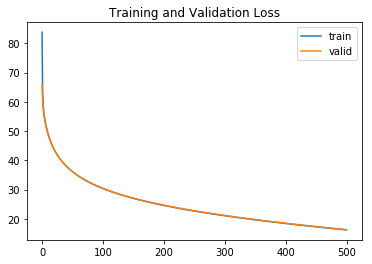

In [21]:
plt.plot(loss, label='train')
plt.plot(val_loss, label='valid')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 用全量数据再训练一下

In [24]:
x_train=tf.convert_to_tensor(train_features_all,dtype=tf.float32)
y_train=tf.convert_to_tensor(train_labels_all,dtype=tf.float32)
x_test=tf.convert_to_tensor(test_features,dtype=tf.float32)

In [25]:
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1)
])
adam=tf.keras.optimizers.Adam(0.5)
model.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_logarithmic_error
              )
model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0)

In [26]:
preds=model.predict(x_test)  # 预测结果
preds[:10]

array([[10871.305 ],
       [ 9857.99  ],
       [11197.828 ],
       [11669.458 ],
       [12823.4795],
       [11259.658 ],
       [11731.108 ],
       [11424.263 ],
       [11436.016 ],
       [10614.987 ]], dtype=float32)

In [ ]:
"""
回归问题的输出层无法使用activation吗？

tf.keras.layers.Dense(1) 这是什么意思？ 就是只有1个神经元呗？

如果按照这个逻辑，那二分类问题，只有一个输出单元就可以了？

均方根误差，对数均方根误差的区别？ 可以根据函数曲线的形状来分析两者的区别，比如有的函数对异常值不敏感。


"""